##### imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.model_selection import GridSearchCV



from keras import layers
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Masking, Flatten


/root/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-09-14 11:05:41.815568: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-14 11:05:42.034813: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-14 11:05:42.083087: W tensorflow/stream_executor/platform/default/

### Import Data

In [2]:
df = pd.read_csv('meteologica.txt', delimiter=';')
df.head(3)

,Observacion,U,V,T
0,512,13,-34,2873
1,726,17,-21,2821
2,730,10,-21,2809


### Preprocess

#### Wind Speed

In [3]:
def add_wind_speed(df):
    return np.sqrt((df['U'] / 20) ** 2 + (df['V'] / 10) ** 2)

#### Wind Direction

In [4]:
def wind_radians_degrees(df):
    radians = np.arctan2(df['U'], df['V'])
    degrees = (np.degrees(radians) + 360) % 360
    return degrees

#### Direction Sector

In [5]:
def direction_sector(df):
    if df['Direction (degrees)'] >= 315 or df['Direction (degrees)'] < 45:
        return 'North'
    elif df['Direction (degrees)'] >= 45 and df['Direction (degrees)'] < 135:
        return 'East'
    elif df['Direction (degrees)'] >= 135 and df['Direction (degrees)'] < 225:
        return 'South'
    else:
        return 'West'

#### Apply Functions

In [6]:
df['Speed (m/ps)'] = df.apply(add_wind_speed, axis=1)
df['Direction (degrees)'] = df.apply(wind_radians_degrees, axis=1)
df['Direction (sector)'] = df.apply(direction_sector, axis=1)

In [7]:
df.head()

,Observacion,U,V,T,Speed (m/ps),Direction (degrees),Direction (sector)
0,512,13,-34,2873,3.461575,159.075498,South
1,726,17,-21,2821,2.265502,141.009006,South
2,730,10,-21,2809,2.158703,154.536655,South
3,844,9,-37,2830,3.727264,166.328693,South
4,948,2,-46,2838,4.601087,177.510447,South


### Section DataFrames

In [8]:
north_df = df[df['Direction (sector)'] == 'North']
east_df = df[df['Direction (sector)'] == 'East']
south_df = df[df['Direction (sector)'] == 'South']
west_df = df[df['Direction (sector)'] == 'West']

### North Sector

#### Linear Regression

##### Four Features

In [9]:
X_n = north_df[['U', 'V', 'Speed (m/ps)', 'Direction (degrees)']]
y_n = north_df['Observacion']

X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_n, 
                                                            y_n, 
                                                            test_size=0.2,
                                                            random_state=42
                                                           )

In [10]:
lin_reg_n = LinearRegression()
lin_reg_n.fit(X_train_n, y_train_n)

display(f'Y-Intercept for north sector: {lin_reg_n.intercept_}')
display(f'Coefficient for north sector: {lin_reg_n.coef_}')

'Y-Intercept for north sector: 18.179260900641225'

'Coefficient for north sector: [ 9.57054295e-01 -2.19890562e+01  2.97981980e+02 -8.38746665e-02]'

In [11]:
y_pred_n = lin_reg_n.predict(X_test_n)

In [12]:
mse_n = round(mean_squared_error(y_test_n, y_pred_n), 2)
rmse_n = round(np.sqrt(mse_n), 2)
mae_n = round(np.mean(np.abs(y_test_n - y_pred_n)), 2)
r2_n = round(r2_score(y_test_n, y_pred_n), 4)

display(f'MSE: {mse_n}')
display(f'RMSE: {rmse_n}')
display(f'MAE: {mae_n}')
display(f'R-squared: {r2_n}')

errors_multi_n = [mse_n, mae_n]

'MSE: 34995.56'

'RMSE: 187.07'

'MAE: 141.07'

'R-squared: 0.5104'

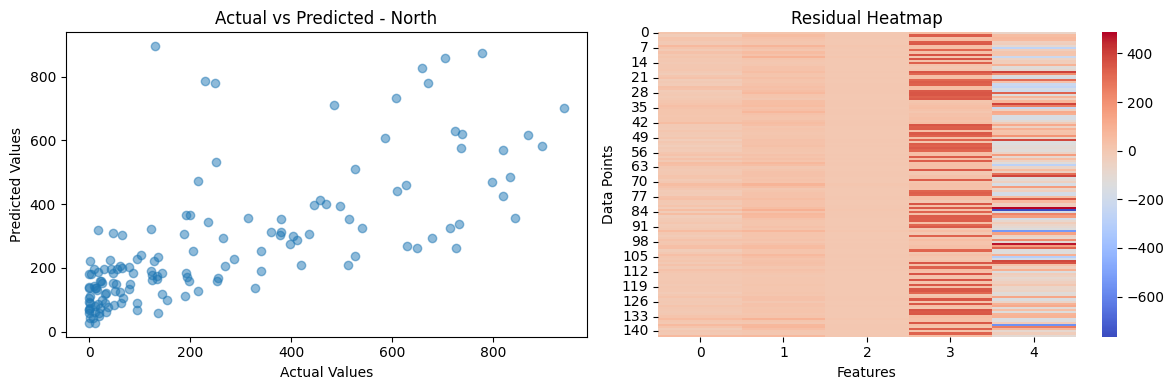

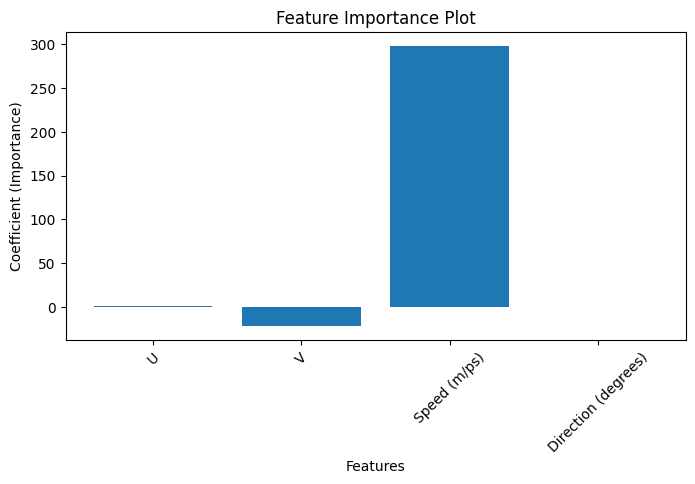

In [13]:
residuals_n = y_test_n - y_pred_n

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.scatter(y_test_n, y_pred_n, alpha=0.5)
plt.title('Actual vs Predicted - North')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')


plt.subplot(122)
residuals_with_features = np.column_stack((X_test_n, residuals_n))
sns.heatmap(residuals_with_features, cmap='coolwarm', annot=False)
plt.title('Residual Heatmap')
plt.xlabel('Features')
plt.ylabel('Data Points')

plt.tight_layout()
plt.show()

feature_importance_n = lin_reg_n.coef_

plt.figure(figsize=(8, 4))
plt.bar(X_n.columns, feature_importance_n)
plt.title('Feature Importance Plot')
plt.xlabel('Features')
plt.ylabel('Coefficient (Importance)')
plt.xticks(rotation=45)
plt.show()

##### One Feature

In [14]:
X_n = north_df[['Speed (m/ps)']]
y_n = north_df['Observacion']

X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_n, 
                                                            y_n, 
                                                            test_size=0.2,
                                                            random_state=42
                                                           )

lin_reg_n = LinearRegression()
lin_reg_n.fit(X_train_n, y_train_n)

display(f'Y-Intercept for north sector: {lin_reg_n.intercept_}')
display(f'Coefficient for north sector: {lin_reg_n.coef_}')

y_pred_n = lin_reg_n.predict(X_test_n)

mse_n = round(mean_squared_error(y_test_n, y_pred_n), 2)
rmse_n = round(np.sqrt(mse_n), 2)
mae_n = round(np.mean(np.abs(y_test_n - y_pred_n)), 2)
r2_n = round(r2_score(y_test_n, y_pred_n), 4)

display(f'MSE: {mse_n}')
display(f'RMSE: {rmse_n}')
display(f'MAE: {mae_n}')
display(f'R-squared: {r2_n}')

errors_single_n = [mse_n, mae_n]

'Y-Intercept for north sector: -15.058458820772074'

'Coefficient for north sector: [95.19881683]'

'MSE: 34048.43'

'RMSE: 184.52'

'MAE: 138.47'

'R-squared: 0.5237'

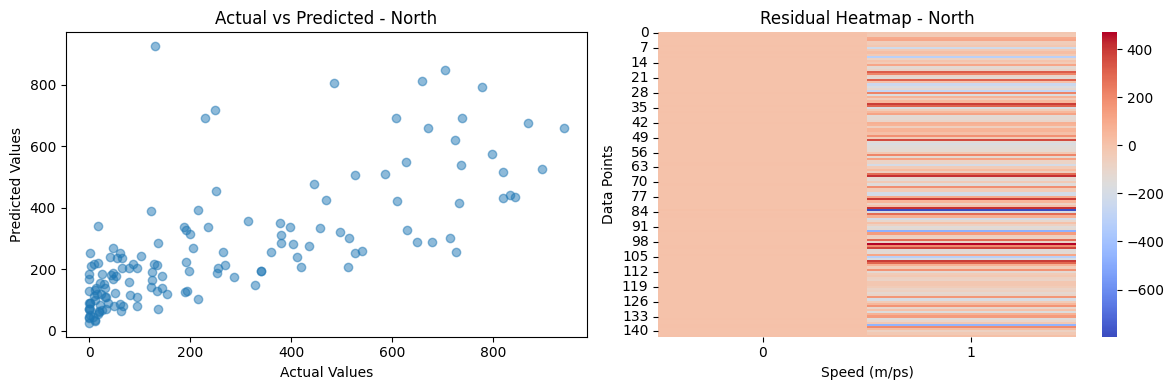

In [15]:
residuals_n = y_test_n - y_pred_n

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.scatter(y_test_n, y_pred_n, alpha=0.5)
plt.title('Actual vs Predicted - North')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')


plt.subplot(122)
residuals_with_features = np.column_stack((X_test_n, residuals_n))
sns.heatmap(residuals_with_features, cmap='coolwarm', annot=False)
plt.title('Residual Heatmap - North')
plt.xlabel('Speed (m/ps)')
plt.ylabel('Data Points')

plt.tight_layout()
plt.show()


#### Deep Learning

In [16]:
def initialize_model_north(input_shape):
    model = Sequential()

    model.add(Dense(units=10, activation='relu', input_shape=input_shape))

    model.add(Dense(units=16, activation='relu'))
    model.add(Dense(units=16, activation='relu'))

    model.add(Dense(units=1, activation='linear'))

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

    return model

In [17]:
es = EarlyStopping(patience = 10, restore_best_weights=True)

input_shape = X_train_n.shape[1:]
model_north = initialize_model_north(input_shape)

model_north.fit(X_train_n,
                y_train_n,
                validation_split = 0.2,
                shuffle = True,
                batch_size=32,
                epochs = 500,
                callbacks = [es],
                verbose = 1
                )

Epoch 1/500


2023-09-14 11:05:44.544977: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-14 11:05:44.545093: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-09-14 11:05:44.545136: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-09-14 11:05:44.545168: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-09-14 11:05:44.545199: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

15/15 [==============================] - 0s 8ms/step - loss: 140084.5000 - mean_absolute_error: 256.7995 - val_loss: 126514.3047 - val_mean_absolute_error: 236.7870
Epoch 2/500
15/15 [==============================] - 0s 3ms/step - loss: 139517.9531 - mean_absolute_error: 256.0604 - val_loss: 126037.8438 - val_mean_absolute_error: 236.1609
Epoch 3/500
15/15 [==============================] - 0s 2ms/step - loss: 138938.7031 - mean_absolute_error: 255.3931 - val_loss: 125526.6016 - val_mean_absolute_error: 235.4979
Epoch 4/500
15/15 [==============================] - 0s 2ms/step - loss: 138319.7344 - mean_absolute_error: 254.6392 - val_loss: 124883.2656 - val_mean_absolute_error: 234.6547
Epoch 5/500
15/15 [==============================] - 0s 2ms/step - loss: 137501.4844 - mean_absolute_error: 253.7344 - val_loss: 124169.3516 - val_mean_absolute_error: 233.7256
Epoch 6/500
15/15 [==============================] - 0s 2ms/step - loss: 136606.9219 - mean_absolute_error: 252.7134 - val_loss

15/15 [==============================] - 0s 2ms/step - loss: 42898.3906 - mean_absolute_error: 165.6759 - val_loss: 39486.0781 - val_mean_absolute_error: 161.1114
Epoch 48/500
15/15 [==============================] - 0s 3ms/step - loss: 42856.4180 - mean_absolute_error: 165.5282 - val_loss: 39475.7773 - val_mean_absolute_error: 160.8566
Epoch 49/500
15/15 [==============================] - 0s 2ms/step - loss: 42822.8281 - mean_absolute_error: 165.3702 - val_loss: 39532.4609 - val_mean_absolute_error: 160.4272
Epoch 50/500
15/15 [==============================] - 0s 2ms/step - loss: 42898.1797 - mean_absolute_error: 165.3468 - val_loss: 39549.5664 - val_mean_absolute_error: 160.1889
Epoch 51/500
15/15 [==============================] - 0s 2ms/step - loss: 42810.2422 - mean_absolute_error: 165.1814 - val_loss: 39415.6836 - val_mean_absolute_error: 160.4269
Epoch 52/500
15/15 [==============================] - 0s 2ms/step - loss: 42812.8477 - mean_absolute_error: 165.1051 - val_loss: 3941

15/15 [==============================] - 0s 2ms/step - loss: 42464.6367 - mean_absolute_error: 162.0473 - val_loss: 38492.1680 - val_mean_absolute_error: 156.8161
Epoch 94/500
15/15 [==============================] - 0s 2ms/step - loss: 42451.6211 - mean_absolute_error: 161.9874 - val_loss: 38520.5703 - val_mean_absolute_error: 156.5664
Epoch 95/500
15/15 [==============================] - 0s 2ms/step - loss: 42477.2500 - mean_absolute_error: 161.9878 - val_loss: 38546.8672 - val_mean_absolute_error: 156.3917
Epoch 96/500
15/15 [==============================] - 0s 2ms/step - loss: 42468.8047 - mean_absolute_error: 161.8989 - val_loss: 38501.6680 - val_mean_absolute_error: 156.3573
Epoch 97/500
15/15 [==============================] - 0s 2ms/step - loss: 42409.6211 - mean_absolute_error: 161.7578 - val_loss: 38484.6680 - val_mean_absolute_error: 156.2848
Epoch 98/500
15/15 [==============================] - 0s 2ms/step - loss: 42413.8281 - mean_absolute_error: 161.7695 - val_loss: 3840

15/15 [==============================] - 0s 2ms/step - loss: 42289.6250 - mean_absolute_error: 159.5624 - val_loss: 37883.6836 - val_mean_absolute_error: 153.8601
Epoch 140/500
15/15 [==============================] - 0s 2ms/step - loss: 42269.7422 - mean_absolute_error: 159.5293 - val_loss: 37907.1992 - val_mean_absolute_error: 153.7514
Epoch 141/500
15/15 [==============================] - 0s 2ms/step - loss: 42326.7500 - mean_absolute_error: 159.5486 - val_loss: 37830.1367 - val_mean_absolute_error: 153.8111
Epoch 142/500
15/15 [==============================] - 0s 2ms/step - loss: 42267.1523 - mean_absolute_error: 159.3497 - val_loss: 37806.3164 - val_mean_absolute_error: 153.7916
Epoch 143/500
15/15 [==============================] - 0s 2ms/step - loss: 42383.0977 - mean_absolute_error: 159.5081 - val_loss: 37744.1680 - val_mean_absolute_error: 153.8724
Epoch 144/500
15/15 [==============================] - 0s 2ms/step - loss: 42214.1992 - mean_absolute_error: 159.2648 - val_loss:

15/15 [==============================] - 0s 2ms/step - loss: 42189.8125 - mean_absolute_error: 158.1240 - val_loss: 37642.2812 - val_mean_absolute_error: 152.0605
Epoch 186/500
15/15 [==============================] - 0s 3ms/step - loss: 42204.5898 - mean_absolute_error: 158.0647 - val_loss: 37571.8633 - val_mean_absolute_error: 152.0842
Epoch 187/500
15/15 [==============================] - 0s 2ms/step - loss: 42195.6562 - mean_absolute_error: 158.0984 - val_loss: 37673.4961 - val_mean_absolute_error: 151.9681
Epoch 188/500
15/15 [==============================] - 0s 2ms/step - loss: 42199.3984 - mean_absolute_error: 158.1041 - val_loss: 37627.0234 - val_mean_absolute_error: 152.0068
Epoch 189/500
15/15 [==============================] - 0s 2ms/step - loss: 42179.4492 - mean_absolute_error: 158.0291 - val_loss: 37563.5430 - val_mean_absolute_error: 152.0262
Epoch 190/500
15/15 [==============================] - 0s 2ms/step - loss: 42206.0625 - mean_absolute_error: 157.9737 - val_loss:

In [18]:
res = model_north.evaluate(X_test_n, y_test_n)

5/5 [==============================] - 0s 1ms/step - loss: 34314.5898 - mean_absolute_error: 142.4668


### West Sector

#### Linear Regression

##### Four Features

In [19]:
X_w = west_df[['U', 'V', 'Speed (m/ps)', 'Direction (degrees)']]
y_w = west_df['Observacion']

X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_w, 
                                                            y_w, 
                                                            test_size=0.2,
                                                            random_state=42
                                                           )

In [20]:
lin_reg_w = LinearRegression()
lin_reg_w.fit(X_train_w, y_train_w)

display(f'Y-Intercept for west sector: {lin_reg_w.intercept_}')
display(f'Coefficient for west sector: {lin_reg_w.coef_}')

'Y-Intercept for west sector: 74.57496126183808'

'Coefficient for west sector: [-10.36556015   1.85033825 -46.58233588  -0.32116984]'

In [21]:
y_pred_w = lin_reg_w.predict(X_test_w)

mse_w = round(mean_squared_error(y_test_w, y_pred_w), 2)
rmse_w = round(np.sqrt(mse_w), 2)
mae_w = round(np.mean(np.abs(y_test_w - y_pred_w)), 2)
r2_w = round(r2_score(y_test_w, y_pred_w), 4)

display(f'MSE: {mse_w}')
display(f'RMSE: {rmse_w}')
display(f'MAE: {mae_w}')
display(f'R-squared: {r2_w}')

errors_multi_w = [mse_w, mae_w]

'MSE: 17491.19'

'RMSE: 132.25'

'MAE: 102.11'

'R-squared: 0.3049'

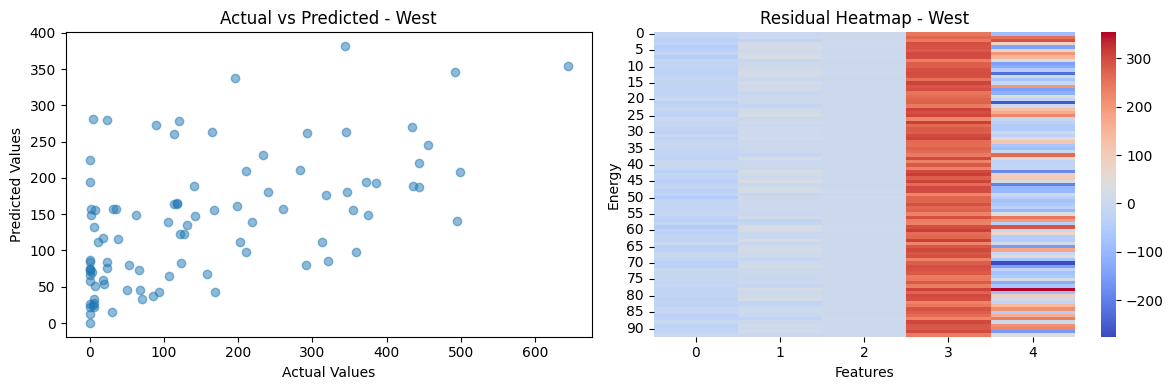

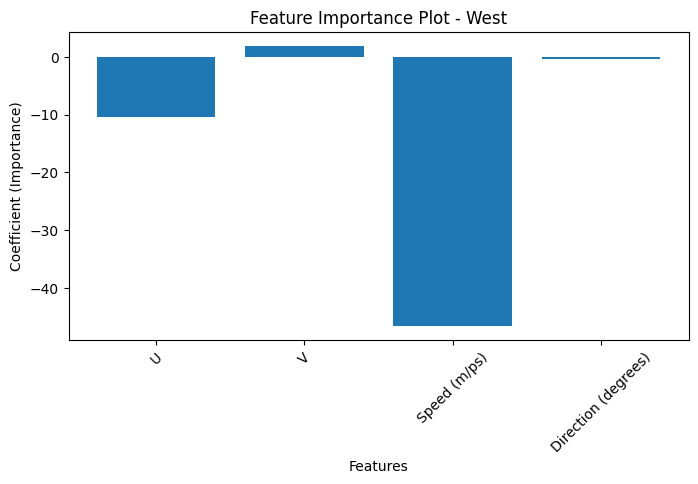

In [22]:
residuals_w = y_test_w - y_pred_w

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.scatter(y_test_w, y_pred_w, alpha=0.5)
plt.title('Actual vs Predicted - West')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

plt.subplot(122)
residuals_with_features_w = np.column_stack((X_test_w, residuals_w))
sns.heatmap(residuals_with_features_w, cmap='coolwarm', annot=False)
plt.title('Residual Heatmap - West')
plt.xlabel('Features')
plt.ylabel('Energy')

plt.tight_layout()
plt.show()

feature_importance_w = lin_reg_w.coef_

plt.figure(figsize=(8, 4))
plt.bar(X_w.columns, feature_importance_w)
plt.title('Feature Importance Plot - West')
plt.xlabel('Features')
plt.ylabel('Coefficient (Importance)')
plt.xticks(rotation=45)
plt.show()

##### One Feature

In [23]:
X_w = west_df[['Speed (m/ps)']]
y_w = west_df['Observacion']

X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_w, 
                                                            y_w, 
                                                            test_size=0.2,
                                                            random_state=42
                                                           )

lin_reg_w = LinearRegression()
lin_reg_w.fit(X_train_w, y_train_w)

display(f'Y-Intercept for west sector: {lin_reg_w.intercept_}')
display(f'Coefficient for west sector: {lin_reg_w.coef_}')

'Y-Intercept for west sector: -2.166246716554639'

'Coefficient for west sector: [98.20145122]'

In [24]:
y_pred_w = lin_reg_w.predict(X_test_w)

mse_w = round(mean_squared_error(y_test_w, y_pred_w), 2)
rmse_w = round(np.sqrt(mse_w), 2)
mae_w = round(np.mean(np.abs(y_test_w - y_pred_w)), 2)
r2_w = round(r2_score(y_test_w, y_pred_w), 4)

display(f'MSE: {mse_w}')
display(f'RMSE: {rmse_w}')
display(f'MAE: {mae_w}')
display(f'R-squared: {r2_w}')

errors_single_w = [mse_w, mae_w]

'MSE: 16939.55'

'RMSE: 130.15'

'MAE: 102.61'

'R-squared: 0.3268'

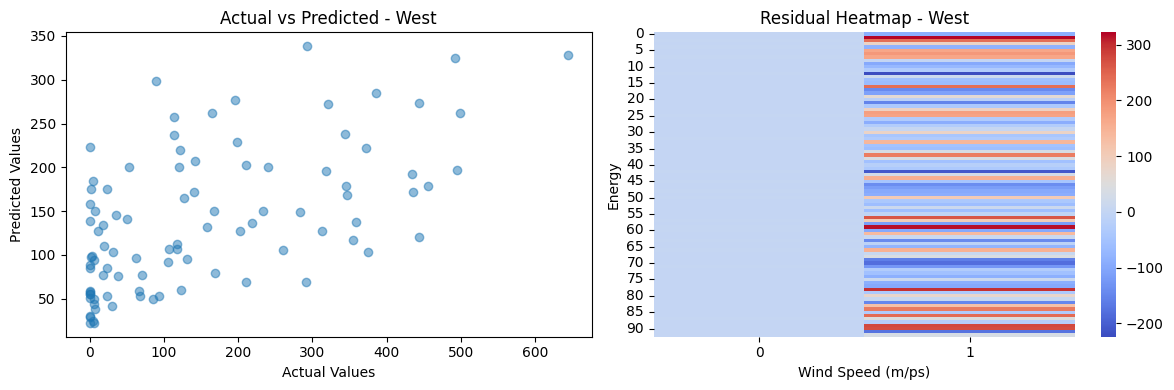

In [25]:
residuals_w = y_test_w - y_pred_w

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.scatter(y_test_w, y_pred_w, alpha=0.5)
plt.title('Actual vs Predicted - West')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

plt.subplot(122)
residuals_with_features_w = np.column_stack((X_test_w, residuals_w))
sns.heatmap(residuals_with_features_w, cmap='coolwarm', annot=False)
plt.title('Residual Heatmap - West')
plt.xlabel('Wind Speed (m/ps)')
plt.ylabel('Energy')

plt.tight_layout()
plt.show()

### South Sector

#### Linear Regression

##### Four Features

In [26]:
X_s = south_df[['U', 'V', 'Speed (m/ps)', 'Direction (degrees)']]
y_s = south_df['Observacion']

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_s, 
                                                            y_s, 
                                                            test_size=0.2,
                                                            random_state=42
                                                           )

In [27]:
lin_reg_s = LinearRegression()
lin_reg_s.fit(X_train_s, y_train_s)

display(f'Y-Intercept for south sector: {lin_reg_s.intercept_}')
display(f'Coefficient for south sector: {lin_reg_s.coef_}')

'Y-Intercept for south sector: 407.0779030089909'

'Coefficient for south sector: [  -0.27995265  -24.70236188 -151.71738775   -2.31873314]'

In [28]:
y_pred_s = lin_reg_s.predict(X_test_s)

mse_s = round(mean_squared_error(y_test_s, y_pred_s), 2)
rmse_s = round(np.sqrt(mse_s), 2)
mae_s = round(np.mean(np.abs(y_test_s - y_pred_s)), 2)
r2_s = round(r2_score(y_test_s, y_pred_s), 4)

display(f'MSE: {mse_s}')
display(f'RMSE: {rmse_s}')
display(f'MAE: {mae_s}')
display(f'R-squared: {r2_s}')

errors_multi_s = [mse_s, mae_s]

'MSE: 57562.5'

'RMSE: 239.92'

'MAE: 193.39'

'R-squared: 0.4124'

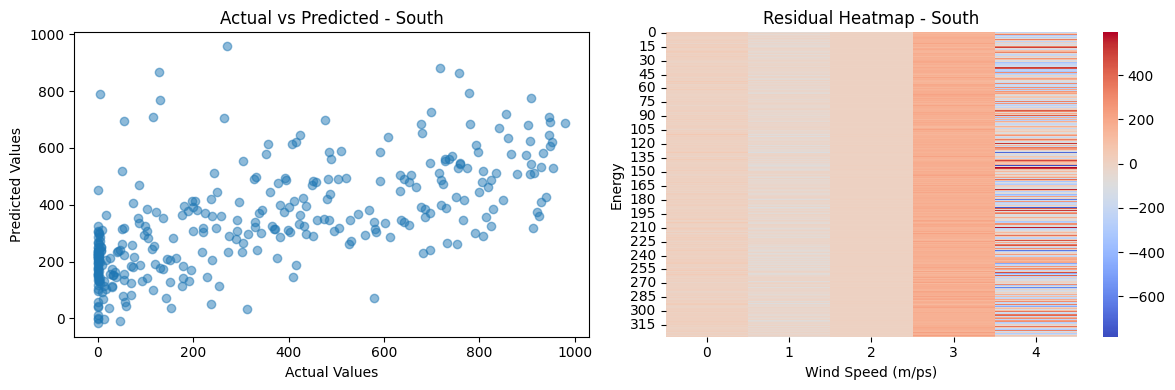

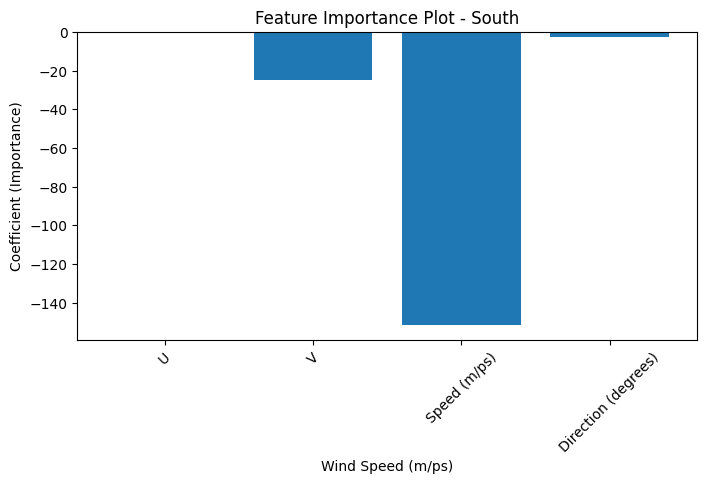

In [29]:
residuals_s = y_test_s - y_pred_s

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.scatter(y_test_s, y_pred_s, alpha=0.5)
plt.title('Actual vs Predicted - South')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

plt.subplot(122)
residuals_with_features_s = np.column_stack((X_test_s, residuals_s))
sns.heatmap(residuals_with_features_s, cmap='coolwarm', annot=False)
plt.title('Residual Heatmap - South')
plt.xlabel('Wind Speed (m/ps)')
plt.ylabel('Energy')

plt.tight_layout()
plt.show()

feature_importance_s = lin_reg_s.coef_

plt.figure(figsize=(8, 4))
plt.bar(X_s.columns, feature_importance_s)
plt.title('Feature Importance Plot - South')
plt.xlabel('Wind Speed (m/ps)')
plt.ylabel('Coefficient (Importance)')
plt.xticks(rotation=45)
plt.show()

##### One Feature

In [30]:
X_s = south_df[['Speed (m/ps)']]
y_s = south_df['Observacion']

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_s, 
                                                            y_s, 
                                                            test_size=0.2,
                                                            random_state=42
                                                           )

In [31]:
lin_reg_s = LinearRegression()
lin_reg_s.fit(X_train_s, y_train_s)

display(f'Y-Intercept for south sector: {lin_reg_s.intercept_}')
display(f'Coefficient for south sector: {lin_reg_s.coef_}')

'Y-Intercept for south sector: -9.034511656847997'

'Coefficient for south sector: [96.45682733]'

In [32]:
y_pred_s = lin_reg_s.predict(X_test_s)

mse_s = round(mean_squared_error(y_test_s, y_pred_s), 2)
rmse_s = round(np.sqrt(mse_s), 2)
mae_s = round(np.mean(np.abs(y_test_s - y_pred_s)), 2)
r2_s = round(r2_score(y_test_s, y_pred_s), 4)

display(f'MSE: {mse_s}')
display(f'RMSE: {rmse_s}')
display(f'MAE: {mae_s}')
display(f'R-squared: {r2_s}')

errors_single_s = [mse_s, mae_s]

'MSE: 60130.56'

'RMSE: 245.22'

'MAE: 198.99'

'R-squared: 0.3862'

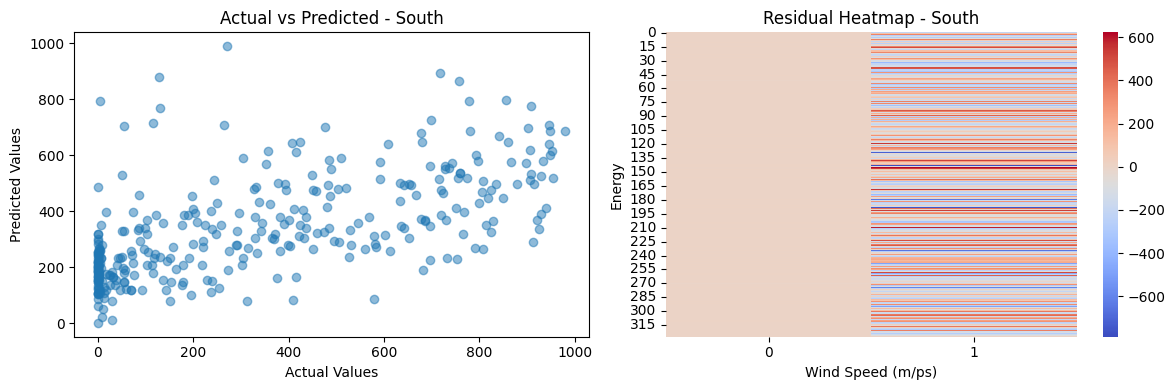

In [33]:
residuals_s = y_test_s - y_pred_s

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.scatter(y_test_s, y_pred_s, alpha=0.5)
plt.title('Actual vs Predicted - South')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

plt.subplot(122)
residuals_with_features_s = np.column_stack((X_test_s, residuals_s))
sns.heatmap(residuals_with_features_s, cmap='coolwarm', annot=False)
plt.title('Residual Heatmap - South')
plt.xlabel('Wind Speed (m/ps)')
plt.ylabel('Energy')

plt.tight_layout()
plt.show()

### East Sector

#### Four Features

In [34]:
X_e = east_df[['U', 'V', 'Speed (m/ps)', 'Direction (degrees)']]
y_e = east_df['Observacion']

X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(X_e, 
                                                            y_e, 
                                                            test_size=0.2,
                                                            random_state=42
                                                           )

In [35]:
lin_reg_e = LinearRegression()
lin_reg_e.fit(X_train_e, y_train_e)

display(f'Y-Intercept for east sector: {lin_reg_e.intercept_}')
display(f'Coefficient for east sector: {lin_reg_e.coef_}')

'Y-Intercept for east sector: -10.449820129245154'

'Coefficient for east sector: [ 6.06417400e+00 -4.47921933e-01  4.98059065e+01 -4.14225840e-02]'

In [36]:
y_pred_e = lin_reg_e.predict(X_test_e)

mse_e = round(mean_squared_error(y_test_e, y_pred_e), 2)
rmse_e = round(np.sqrt(mse_e), 2)
mae_e = round(np.mean(np.abs(y_test_e - y_pred_e)), 2)
r2_e = round(r2_score(y_test_e, y_pred_e), 4)

display(f'MSE: {mse_e}')
display(f'RMSE: {rmse_e}')
display(f'MAE: {mae_e}')
display(f'R-squared: {r2_e}')

errors_multi_e = [mse_e, mae_e]

'MSE: 38561.48'

'RMSE: 196.37'

'MAE: 155.08'

'R-squared: 0.4709'

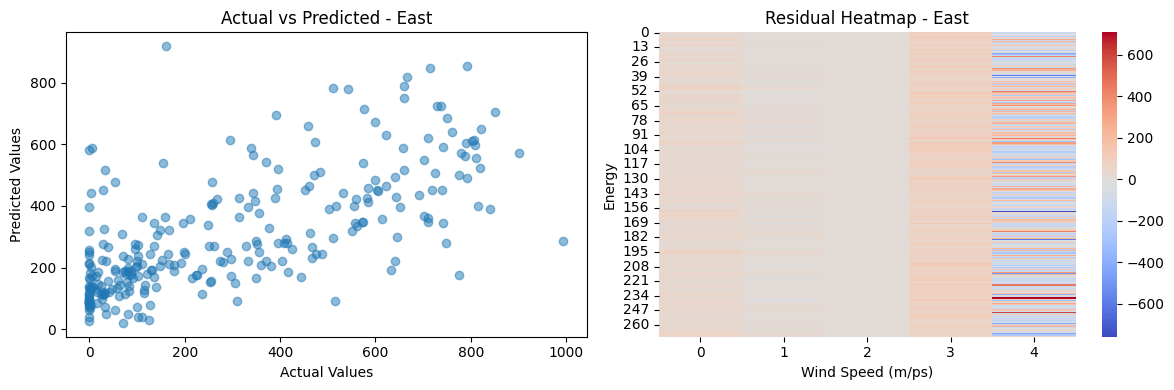

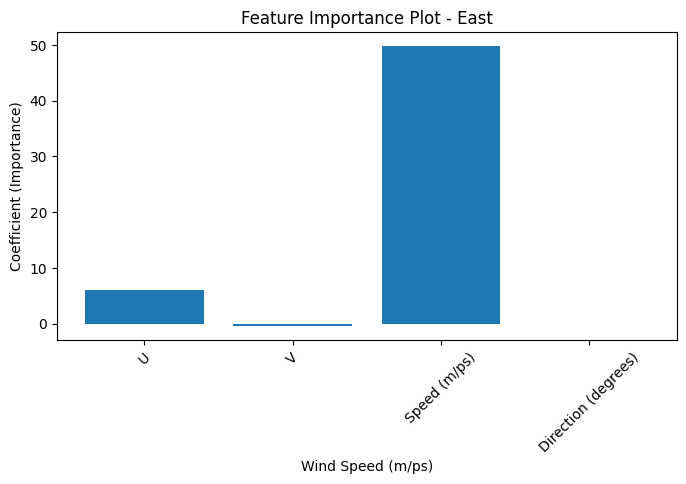

In [37]:
residuals_e = y_test_e - y_pred_e

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.scatter(y_test_e, y_pred_e, alpha=0.5)
plt.title('Actual vs Predicted - East')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

plt.subplot(122)
residuals_with_features_e = np.column_stack((X_test_e, residuals_e))
sns.heatmap(residuals_with_features_e, cmap='coolwarm', annot=False)
plt.title('Residual Heatmap - East')
plt.xlabel('Wind Speed (m/ps)')
plt.ylabel('Energy')

plt.tight_layout()
plt.show()

feature_importance_e = lin_reg_e.coef_

plt.figure(figsize=(8, 4))
plt.bar(X_e.columns, feature_importance_e)
plt.title('Feature Importance Plot - East')
plt.xlabel('Wind Speed (m/ps)')
plt.ylabel('Coefficient (Importance)')
plt.xticks(rotation=45)
plt.show()

##### One Feature

In [38]:
X_e = east_df[['Speed (m/ps)']]
y_e = east_df['Observacion']

X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(X_e, 
                                                            y_e, 
                                                            test_size=0.2,
                                                            random_state=42
                                                           )

In [39]:
lin_reg_e = LinearRegression()
lin_reg_e.fit(X_train_e, y_train_e)

display(f'Y-Intercept for east sector: {lin_reg_e.intercept_}')
display(f'Coefficient for east sector: {lin_reg_e.coef_}')

'Y-Intercept for east sector: 10.111979368800348'

'Coefficient for east sector: [128.95026404]'

In [40]:
y_pred_e = lin_reg_e.predict(X_test_e)

mse_e = round(mean_squared_error(y_test_e, y_pred_e), 2)
rmse_e = round(np.sqrt(mse_e), 2)
mae_e = round(np.mean(np.abs(y_test_e - y_pred_e)), 2)
r2_e = round(r2_score(y_test_e, y_pred_e), 4)

display(f'MSE: {mse_e}')
display(f'RMSE: {rmse_e}')
display(f'MAE: {mae_e}')
display(f'R-squared: {r2_e}')

errors_single_e = [mse_e, mae_e]

'MSE: 43453.83'

'RMSE: 208.46'

'MAE: 165.1'

'R-squared: 0.4037'

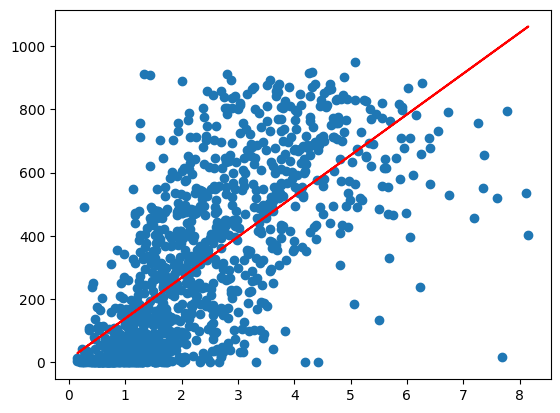

In [41]:
plt.scatter(X_train_e, y_train_e)

predicted_values = lin_reg_e.coef_ * X_train_e + lin_reg_e.intercept_

plt.plot(X_train_e, predicted_values, color='red', label='Regression Line');

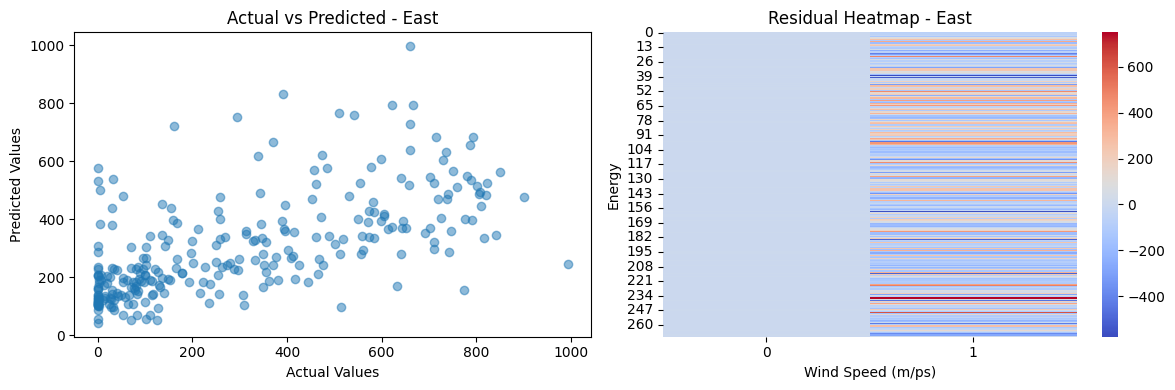

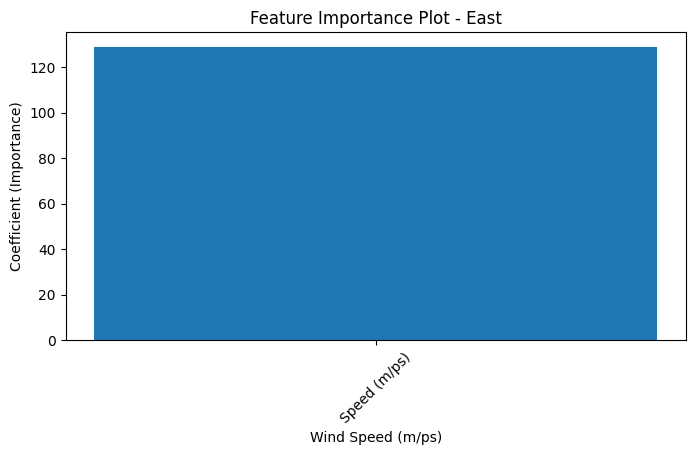

In [45]:
residuals_e = y_test_e - y_pred_e

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.scatter(y_test_e, y_pred_e, alpha=0.5)
plt.title('Actual vs Predicted - East')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

plt.subplot(122)
residuals_with_features_e = np.column_stack((X_test_e, residuals_e))
sns.heatmap(residuals_with_features_e, cmap='coolwarm', annot=False)
plt.title('Residual Heatmap - East')
plt.xlabel('Wind Speed (m/ps)')
plt.ylabel('Energy')

plt.tight_layout()
plt.show()

feature_importance_e = lin_reg_e.coef_

plt.figure(figsize=(8, 4))
plt.bar(X_e.columns, feature_importance_e)
plt.title('Feature Importance Plot - East')
plt.xlabel('Wind Speed (m/ps)')
plt.ylabel('Coefficient (Importance)')
plt.xticks(rotation=45)
plt.show()

#### Results

In [46]:
columns = ['North', 'East', 'South', 'West']

mae_single = [errors_single_n[1], errors_single_e[1], errors_single_s[1], errors_single_w[1]]
mae_multi = [errors_multi_n[1], errors_multi_e[1], errors_multi_s[1], errors_multi_w[1]]
mse_single = [errors_single_n[0], errors_single_e[0], errors_single_s[0], errors_single_w[0]]
mse_multi = [errors_multi_n[0], errors_multi_e[0], errors_multi_s[0], errors_multi_w[0]]

combined = [mae_single, mae_multi, mse_single, mse_multi]




results_df = pd.DataFrame(data=combined, columns=columns)

results_df.index = ['MAE - 1', 'MAE - 4', 'MSE - 1', 'MSE - 4']

In [47]:
results_df.head()

,North,East,South,West
MAE - 1,138.47,165.10,198.99,102.61
MAE - 4,141.07,155.08,193.39,102.11
MSE - 1,34048.43,43453.83,60130.56,16939.55
MSE - 4,34995.56,38561.48,57562.50,17491.19
